In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import cm

import plotly.express as px
import networkx as nx
from pyproj import Proj, transform 
from mpl_toolkits.basemap import Basemap as Basemap

import geopandas as gpd  # gpd.__version__  # gpd.show_versions()
import shapely
import shapely.geometry as geom
from shapely.geometry import LineString

import time

In [2]:
from map_function import read_csv, read_shp, flow_map, flow_map1

df1 = read_shp('new1/anpr_epsg4326.shp')  # perhaps try using python to convert to epsg4326 later
file = r'new1/test0820_epsg4326'          # path of the generated output shapefile (road curved lines)

In [3]:
# change names later  # current subtitle = location+' '+datetime+' '+vehicle
title = 'Cambridge Road Map'

datetime = '22 Aug xxpm'
vehicle = 'car'
location = 'Cambridge'  

legend_title = 'Group Count'

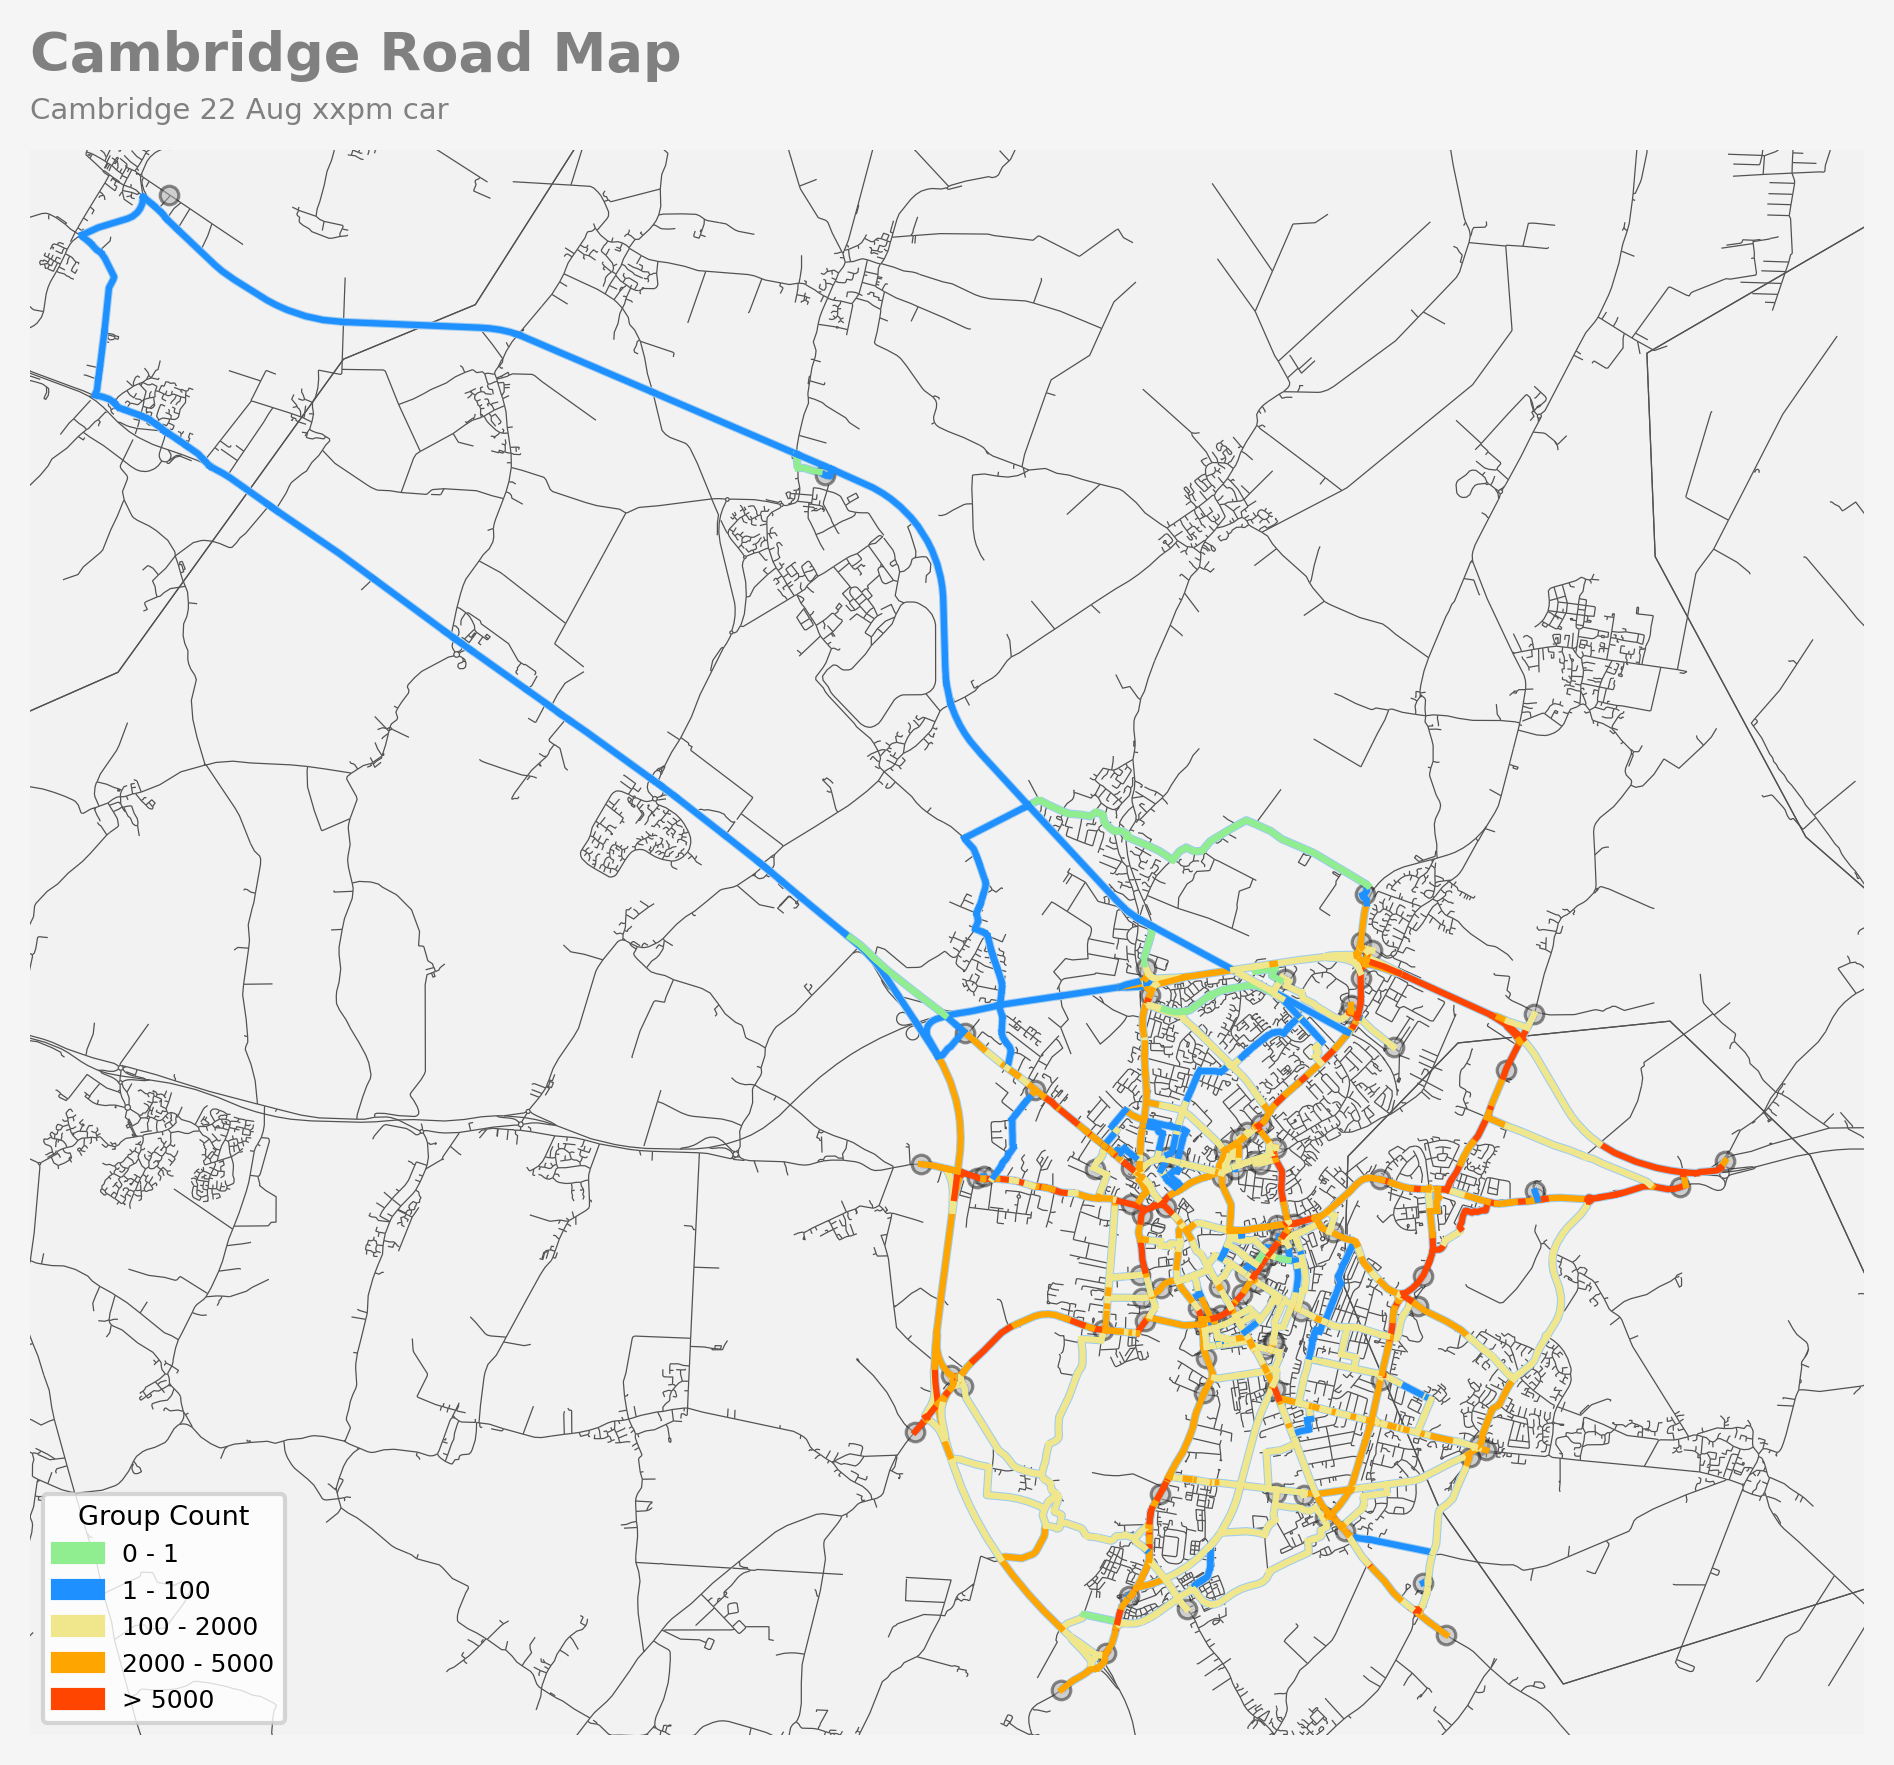

Elapsed time is: 7.8645 seconds


In [4]:
# new version: directly based on shapefile (curved line, more accurate)

start_time = time.time()

flow_map(file,title,datetime,vehicle,location,legend_title)

print("Elapsed time is: %.4f seconds" % (time.time() - start_time))

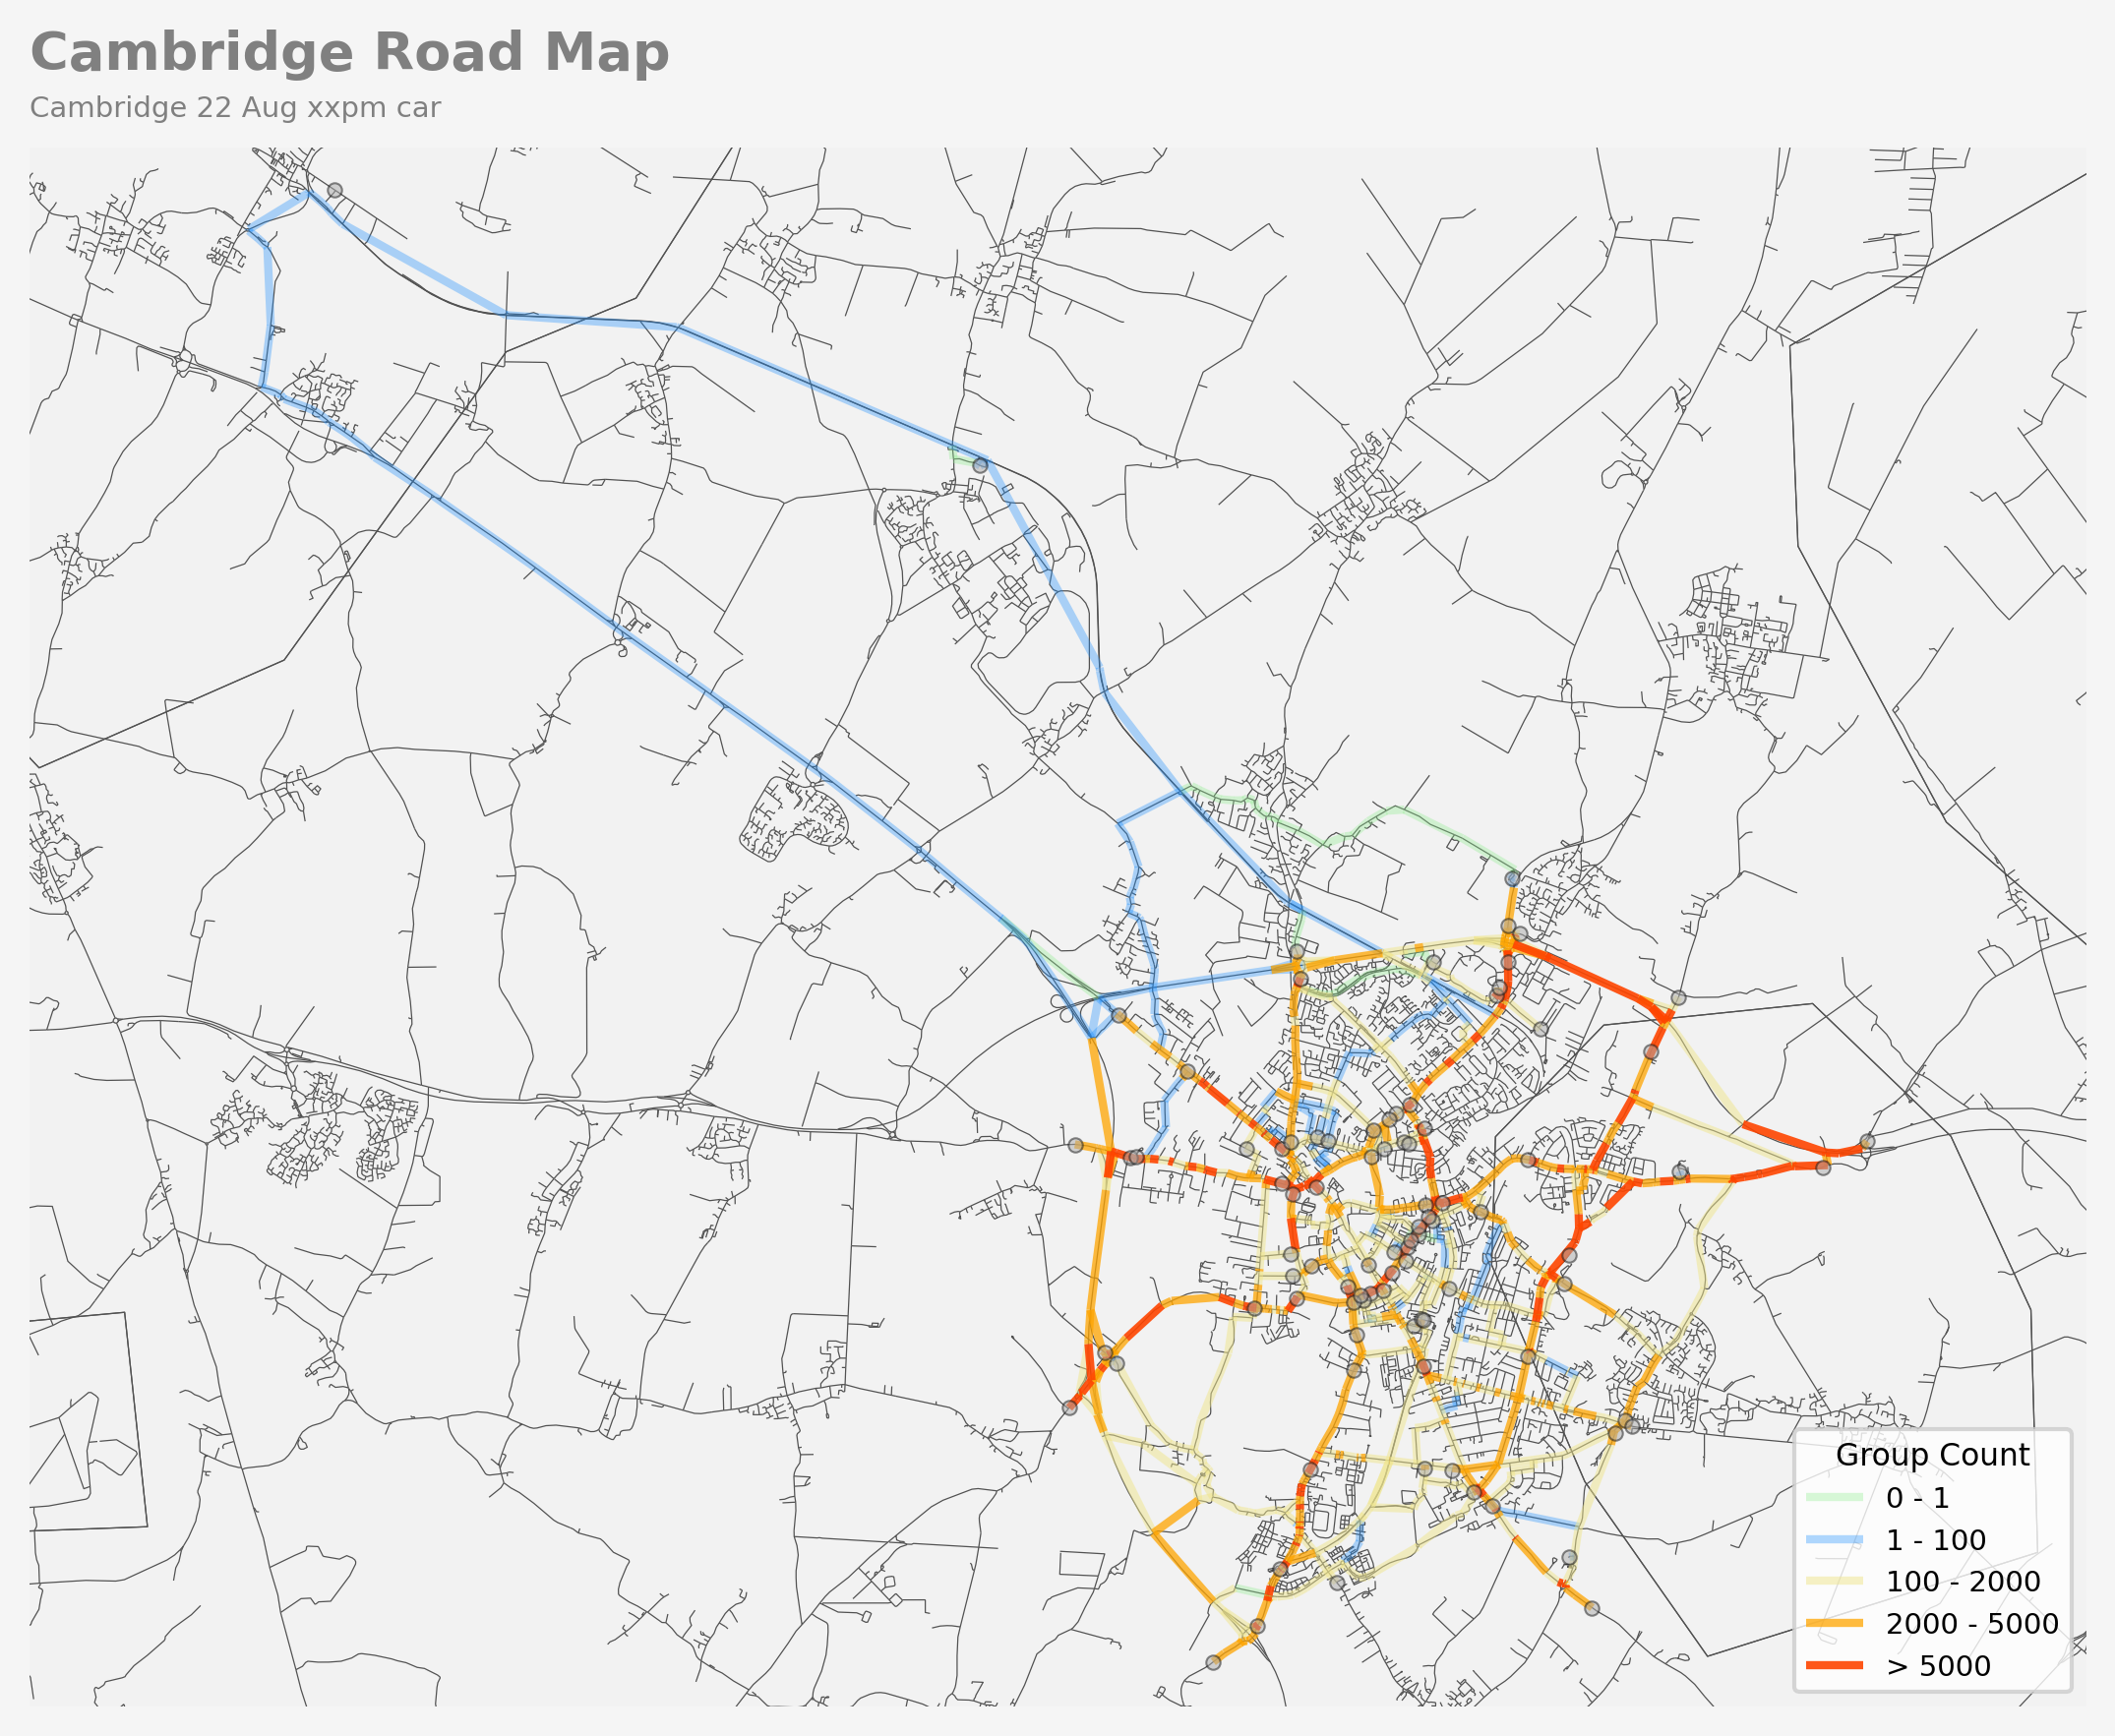

Elapsed time is: 5.6799 seconds


In [5]:
# old version - based on points and connect to the stright line (run slightly faster, but not very accurate)
start_time = time.time()

df = read_csv('with nodes coordinates.csv')
flow_map1(title,datetime,vehicle,location,legend_title)

print("Elapsed time is: %.4f seconds" % (time.time() - start_time))